In [17]:
import os, sys
from os.path import expanduser
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pprint
import neuroh5
from neuroh5.io import read_population_ranges, read_population_names, read_cell_attributes, scatter_read_cell_attribute_selection
import dentate
from dentate import utils, plot, stimulus, spikedata
from dentate.env import Env
from dentate.stimulus import rate_maps_from_features
from dentate.utils import contiguous_ranges, viewitems


In [2]:
dataset_prefix='/media/igr/d865f900-7fcd-45c7-a7a7-bd2a7391bc40/Data/DG'
population='GC'
target_features_path = f'{dataset_prefix}/Full_Scale_Control/DG_input_features_20200910_compressed.h5'
target_features_namespace = 'Place Selectivity'
cell_index_set = set([245244])

In [14]:
def read_input_features(env, input_features_path, input_features_namespace, arena_id, pop_name, cell_index_set):
    
    input_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate',                          
                                 'Module ID', 'Grid Spacing', 'Grid Orientation',                                       
                                 'Field Width Concentration Factor',                                                    
                                 'X Offset', 'Y Offset']
    
    this_input_features_namespace = f'{input_features_namespace} {arena_id}'
    
    input_features_iter = scatter_read_cell_attribute_selection(input_features_path, pop_name,                          
                                                                selection=cell_index_set,                               
                                                                namespace=this_input_features_namespace,                
                                                                mask=set(input_features_attr_names),                    
                                                                comm=env.comm, io_size=env.io_size)                     
    
    results = {}
    for gid, selectivity_attr_dict in input_features_iter:                                                              
                                                                                                                        
        this_selectivity_type = selectivity_attr_dict['Selectivity Type'][0]                                            
        this_selectivity_type_name = selectivity_type_names[this_selectivity_type]                                      
        input_cell_config = get_input_cell_config(selectivity_type=this_selectivity_type,                               
                                                  selectivity_type_names=selectivity_type_names,                        
                                                  selectivity_attr_dict=selectivity_attr_dict)                          
        results[gid] = input_cell_config
        
    return results

def range_inds(rs):                                                                                                 
    l = list(rs)                                                                                                    
    if len(l) > 0:                                                                                                  
        a = np.concatenate(l)                                                                                       
    else:                                                                                                           
        a = None                                                                                                    
    return a                                                                                                        


In [5]:
env = Env(config_file='Network_Clamp_GC_Exc_Sat_SLN_IN_Izh_proximal_pf.yaml',
          config_prefix='../config')

arena_id='A'
trajectory_id='Diag'

target_rate_vector_dict = \
  rate_maps_from_features (env, population, 
                           target_features_path, 
                           target_features_namespace, 
                           cell_index_set, 
                           arena_id=arena_id, 
                           trajectory_id=trajectory_id,
                           include_time=True)

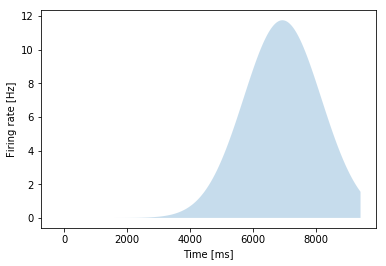

In [8]:
target_rate_time, target_rate = target_rate_vector_dict[245244]
plt.figure()
plt.fill_between(target_rate_time, 0, target_rate, alpha=0.25);
plt.xlabel('Time [ms]');
plt.ylabel('Firing rate [Hz]');


In [16]:
infld_idxs_dict = { gid: np.where(target_rate_vector > 1e-4)[0]                                                     
                    for gid, (_, target_rate_vector) in viewitems(target_rate_vector_dict) }                             
peak_pctile_dict = { gid: np.percentile(target_rate_vector_dict[gid][1][infld_idxs], 80)                               
                     for gid, infld_idxs in viewitems(infld_idxs_dict) }                                            
trough_pctile_dict = { gid: np.percentile(target_rate_vector_dict[gid][1][infld_idxs], 20)                             
                       for gid, infld_idxs in viewitems(infld_idxs_dict) }                                          
outfld_idxs_dict = { gid: range_inds(contiguous_ranges(target_rate_vector < 1e-4, return_indices=True))             
                     for gid, (_, target_rate_vector) in viewitems(target_rate_vector_dict) }                             

peak_idxs_dict = { gid: range_inds(contiguous_ranges(target_rate_vector >= peak_pctile_dict[gid], return_indices=True))                                                                                                                    
                    for gid, (_, target_rate_vector) in viewitems(target_rate_vector_dict) }                              
trough_idxs_dict = { gid: range_inds(contiguous_ranges(np.logical_and(target_rate_vector > 0., target_rate_vector <= trough_pctile_dict[gid]), return_indices=True))                                                                       
                     for gid, (_, target_rate_vector) in viewitems(target_rate_vector_dict) }                            

target_rate_features_dict = {}
for gid, (_, target_rate_vector) in viewitems(target_rate_vector_dict):
    infld_idxs = infld_idxs_dict[gid]
    peak_idxs = peak_idxs_dict[gid]
    trough_idxs = trough_idxs_dict[gid]
    target_infld = target_rate_vector[infld_idxs]                                                                   
    target_max_infld = np.max(target_infld)                                                                         
    target_mean_peak = np.mean(target_rate_vector[peak_idxs])
    target_mean_trough = np.mean(target_rate_vector[trough_idxs])                                                   
    target_rate_features_dict[gid] = {'max_infld': target_max_infld,
                                      'target_mean_peak': target_mean_peak,
                                      'target_mean_trough': target_mean_trough}

In [18]:
pprint.pprint(target_rate_features_dict)

{245244: {'max_infld': 11.754471805369079,
          'target_mean_peak': 11.01156885500988,
          'target_mean_trough': 0.025440412593718372}}
